In [ ]:
#%%

# import os
# %load_ext autoreload
# %autoreload 2

## Do not preallocate GPU memory
# os.environ["XLA_PYTHON_CLIENT_ALLOCATOR"] = '\"platform\"'

from nodax import *
# jax.config.update("jax_debug_nans", True)

## Execute jax on CPU
# jax.config.update("jax_platform_name", "cpu")


############# Neural Context Flow #############

Jax version: 0.4.35
Available devices: [CudaDevice(id=0)]


In [ ]:
#%%

seed = 2026
# seed = int(np.random.randint(0, 10000))

## Neural Context Flow hyperparameters ##
context_pool_size = 2               ## Number of neighboring contexts j to use for a flow in env e
context_size = 256
print_error_every = 100
integrator = diffrax.Dopri5
# integrator = RK4
ivp_args = {"dt_init":1e-4, "rtol":1e-3, "atol":1e-6, "max_steps":40000, "subdivisions":5}
## subdivision is used for non-adaptive integrators like RK4. It's the number of extra steps to take between each evaluation time point
# run_folder = "./runs/09032024-155347/"      ## Run folder to use when not training
run_folder = "./runs/28032024-201048/"

## Training hyperparameters ##
train = True
save_trainer = True
finetune = False

init_lr = 1e-4
sched_factor = 1.0

nb_outer_steps_max = 600
nb_inner_steps_max = 10
proximal_beta = 1e2 ## See beta in https://proceedings.mlr.press/v97/li19n.html
inner_tol_node = 1e-9
inner_tol_ctx = 1e-8
early_stopping_patience = nb_outer_steps_max//1       ## Number of outer steps to wait before early stopping


## Adaptation hyperparameters ##
adapt_test = True
adapt_restore = True

init_lr_adapt = 5e-3
sched_factor_adapt = 0.5
nb_epochs_adapt = 1500

In [ ]:
#%%

if train == True:

    # check that 'tmp' folder exists. If not, create it
    if not os.path.exists('./runs'):
        os.mkdir('./runs')

    # Make a new folder inside 'tmp' whose name is the current time
    # run_folder = './runs/'+time.strftime("%d%m%Y-%H%M%S")+'/'
    run_folder = "./runs/23012024-163033-T2/"
    if not os.path.exists(run_folder):
        os.mkdir(run_folder)
    print("Run folder created successfuly:", run_folder)

    # Save the run and dataset scripts in that folder
    script_name = os.path.basename(__file__)
    os.system(f"cp {script_name} {run_folder}")
    os.system(f"cp dataset.py {run_folder}")

    # Save the nodax module files as well
    os.system(f"cp -r ../../nodax {run_folder}")
    print("Completed copied scripts ")


else:
    # run_folder = "./runs/22022024-112457/"  ## Needed for loading the model and finetuning TODO: opti
    print("No training. Loading data and results from:", run_folder)

## Create a folder for the adaptation results
adapt_folder = run_folder+"adapt/"
if not os.path.exists(adapt_folder):
    os.mkdir(adapt_folder)

Run folder created successfuly: ./runs/23012024-163033-T2/
Completed copied scripts 


In [ ]:
#%%

if train == True:
    # Run the dataset script to generate the data
    os.system(f'python dataset.py --split=train --savepath="{run_folder}" --seed="{seed}"')
    os.system(f'python dataset.py --split=test --savepath="{run_folder}" --seed="{seed*2}"')

Running this script in ipython (Jupyter) session ? False
=== Parsed arguments to generate data ===
 Split: train
 Savepath: ./runs/23012024-163033-T2/
 Seed: 2026

Running this script in ipython (Jupyter) session ? False
=== Parsed arguments to generate data ===
 Split: test
 Savepath: ./runs/23012024-163033-T2/
 Seed: 4052



In [ ]:
#%%

## Define dataloader for training and validation
train_dataloader = DataLoader(run_folder+"train_data.npz", batch_size=-1, shuffle=True, key=seed)

nb_envs = train_dataloader.nb_envs
nb_trajs_per_env = train_dataloader.nb_trajs_per_env
nb_steps_per_traj = train_dataloader.nb_steps_per_traj
data_size = train_dataloader.data_size

val_dataloader = DataLoader(run_folder+"test_data.npz", shuffle=False)

In [ ]:
#%%

## Define model and loss function for the learner

class Swish(eqx.Module):
    beta: jnp.ndarray
    def __init__(self, key=None):
        self.beta = jax.random.uniform(key, shape=(1,), minval=0.01, maxval=1.0)
    def __call__(self, x):
        return x * jax.nn.sigmoid(self.beta * x)

class Augmentation(eqx.Module):
    layers_data: list
    layers_context: list
    layers_shared: list
    activations: list

    def __init__(self, data_size, int_size, context_size, key=None):
        keys = generate_new_keys(key, num=12)
        self.activations = [Swish(key=key_i) for key_i in keys[:7]]

        self.layers_context = [eqx.nn.Linear(context_size, context_size//4, key=keys[0]), self.activations[0],
                               eqx.nn.Linear(context_size//4, int_size, key=keys[1]), self.activations[1], eqx.nn.Linear(int_size, int_size, key=keys[2])]

        self.layers_data = [eqx.nn.Linear(data_size, int_size, key=keys[3]), self.activations[2], 
                            eqx.nn.Linear(int_size, int_size, key=keys[4]), self.activations[3], 
                            eqx.nn.Linear(int_size, int_size, key=keys[5])]

        self.layers_shared = [eqx.nn.Linear(2*int_size, int_size, key=keys[6]), self.activations[4], 
                              eqx.nn.Linear(int_size, int_size, key=keys[7]), self.activations[5], 
                              eqx.nn.Linear(int_size, int_size, key=keys[8]), self.activations[6], 
                              eqx.nn.Linear(int_size, data_size, key=keys[9])]

    def __call__(self, t, y, ctx):

        for layer in self.layers_context:
            ctx = layer(ctx)

        for layer in self.layers_data:
            y = layer(y)

        y = jnp.concatenate([y, ctx], axis=0)
        for layer in self.layers_shared:
            y = layer(y)

        return y

class ContextFlowVectorField(eqx.Module):
    physics: eqx.Module
    augmentation: eqx.Module

    def __init__(self, augmentation, physics=None):
        self.augmentation = augmentation
        self.physics = physics

    def __call__(self, t, x, ctxs):
        ctx, ctx_ = ctxs

        if self.physics is None:
            vf = lambda xi: self.augmentation(t, x, xi)
        else:
            vf = lambda xi: self.physics(t, x, xi) + self.augmentation(t, x, xi)

        gradvf = lambda xi_: eqx.filter_jvp(vf, (xi_,), (ctx-xi_,))[1]
        scd_order_term = eqx.filter_jvp(gradvf, (ctx_,), (ctx-ctx_,))[1]

        return vf(ctx_) + 1.5*gradvf(ctx_) + 0.5*scd_order_term


augmentation = Augmentation(data_size=2, int_size=64, context_size=context_size, key=seed)

# physics = Physics(key=seed)
physics = None

vectorfield = ContextFlowVectorField(augmentation, physics=physics)

print("\n\nTotal number of parameters in the model:", sum(x.size for x in jax.tree_util.tree_leaves(eqx.filter(vectorfield,eqx.is_array)) if x is not None), "\n\n")

contexts = ContextParams(nb_envs, context_size, key=None)

## Define a custom loss function here
def loss_fn_ctx(model, trajs, t_eval, ctx, all_ctx_s, key):

    # ind = jax.random.randint(key, shape=(context_pool_size,), minval=0, maxval=all_ctx_s.shape[0])
    # ind = jax.random.permutation(key, all_ctx_s.shape[0])[:context_pool_size]

    ## Sort the contexts by their distance to ctx, and get the closest - NF strategy !!!
    ind = jnp.argsort(jnp.mean(jnp.abs(all_ctx_s-ctx), axis=1))[:context_pool_size]
    ctx_s = all_ctx_s[ind, :]

    # jax.debug.print("indices chosen for this loss {}", ind)

    trajs_hat, nb_steps = jax.vmap(model, in_axes=(None, None, None, 0))(trajs[:, 0, :], t_eval, ctx, ctx_s)
    new_trajs = jnp.broadcast_to(trajs, trajs_hat.shape)

    term1 = jnp.mean((new_trajs-trajs_hat)**2)  ## reconstruction
    # term2 = jnp.mean(ctx**2)             ## regularisation
    term2 = jnp.mean(jnp.abs(ctx))             ## regularisation
    # term2 = params_norm_squared(ctx)
    term3 = params_norm_squared(model)

    loss_val = term1 + 1e-3*term2 + 1e-3*term3
    # loss_val = jnp.nan_to_num(term1, nan=0.0, posinf=0.0, neginf=0.0)
    # loss_val = term1

    return loss_val, (jnp.sum(nb_steps)/ctx_s.shape[0], term1, term2)


learner = Learner(vectorfield, contexts, loss_fn_ctx, integrator, ivp_args, key=seed)



Total number of parameters in the model: 50000 




In [ ]:
#%%

## Define optimiser and traine the model

nb_total_epochs = nb_outer_steps_max * 1
sched_node = optax.piecewise_constant_schedule(init_value=init_lr,
                        boundaries_and_scales={nb_total_epochs//3:sched_factor, 2*nb_total_epochs//3:sched_factor})

sched_ctx = optax.piecewise_constant_schedule(init_value=init_lr,
                        boundaries_and_scales={nb_total_epochs//3:sched_factor, 2*nb_total_epochs//3:sched_factor})

opt_node = optax.adam(sched_node)
opt_ctx = optax.adam(sched_ctx)

trainer = Trainer(train_dataloader, learner, (opt_node, opt_ctx), key=seed)

In [ ]:
#%%

trainer_save_path = run_folder if save_trainer == True else False
if train == True:
    # for i, prop in enumerate(np.linspace(0.25, 1.0, 3)):
    for i, prop in enumerate(np.linspace(1.0, 1.0, 1)):
        # trainer.dataloader.int_cutoff = int(prop*nb_steps_per_traj)
        # trainer.train(nb_epochs=nb_epochs*(2**0), print_error_every=print_error_every*(2**0), update_context_every=1, save_path=trainer_save_path, key=seed, val_dataloader=val_dataloader, int_prop=prop)
        trainer.train_proximal(nb_outer_steps_max=nb_outer_steps_max, 
                               nb_inner_steps_max=nb_inner_steps_max, 
                               proximal_reg=proximal_beta, 
                               inner_tol_node=inner_tol_node, 
                               inner_tol_ctx=inner_tol_ctx,
                               print_error_every=print_error_every*(2**0), 
                               save_path=trainer_save_path, 
                               val_dataloader=val_dataloader, 
                               patience=early_stopping_patience,
                               int_prop=prop,
                               key=seed)

else:
    # print("\nNo training, attempting to load model and results from "+ run_folder +" folder ...\n")

    restore_folder = run_folder
    # restore_folder = "./runs/27012024-155719/finetune_193625/"
    trainer.restore_trainer(path=restore_folder)



=== Beginning training with proximal alternating minimization ... ===
    Number of examples in a batch: 4
    Maximum number of steps per inner minimization: 10
    Maximum number of outer minimizations: 600
    Maximum total number of training steps: 6000

Compiling function "train_step" for neural ode ...
Shapes of elements in a batch: (25, 4, 40, 2) (40,)

Compiling function "train_step" for context ...
Shapes of elements in a batch: (25, 4, 40, 2) (40,)
    Outer Step:     0      LossTrajs: 1.32734132     ContextsNorm: 0.00000000     ValIndCrit: 1.50186503
        Saving best model so far ...
        -NbInnerStepsNode:    1
        -NbInnerStepsCxt:    1
        -InnerToleranceNode: 1.00e-09
        -InnerToleranceCtx:  1.00e-08
        -DiffNode: 1.65e-06
        -DiffCxt:  inf
    Outer Step:     1      LossTrajs: 1.30465269     ContextsNorm: 0.00022067     ValIndCrit: 1.47455728
        Saving best model so far ...
        -NbInnerStepsNode:   10
        -NbInnerStepsCxt:   1

In [ ]:
#%%

if finetune:
    # ## Finetune a trained model

    finetunedir = run_folder+"finetune_"+trainer.dataloader.data_id+"/"
    if not os.path.exists(finetunedir):
        os.mkdir(finetunedir)
    print("No training. Loading anctx_sd finetuning into:", finetunedir)

    trainer.dataloader.int_cutoff = nb_steps_per_traj

    opt_node = optax.adabelief(1e-7)
    opt_ctx = optax.adabelief(1e-7)
    trainer.opt_node, trainer.opt_ctx = opt_node, opt_ctx

    # trainer.opt_node_state = trainer.opt_node.init(eqx.filter(trainer.learner.neuralode, eqx.is_array))
    # trainer.opt_ctx_state = trainer.opt_ctx.init(trainer.learner.contexts)

    trainer.train(nb_epochs=24000, print_error_every=1000, update_context_every=1, save_path=finetunedir, key=seed)

==  Begining in-domain testing ... ==
    Number of training environments: 25
    Final length of the training trajectories: 40
    Length of the testing trajectories: 40
Test Score (In-Domain): 0.026552722

==  Begining in-domain visualisation ... ==
    Environment id: 0
    Trajectory id: 5
    Visualized dimensions: (0, 1)
    Final length of the training trajectories: 40
    Length of the testing trajectories: 40
Testing finished. Figure saved in: ./runs/23012024-163033-T2/results_in_domain.png


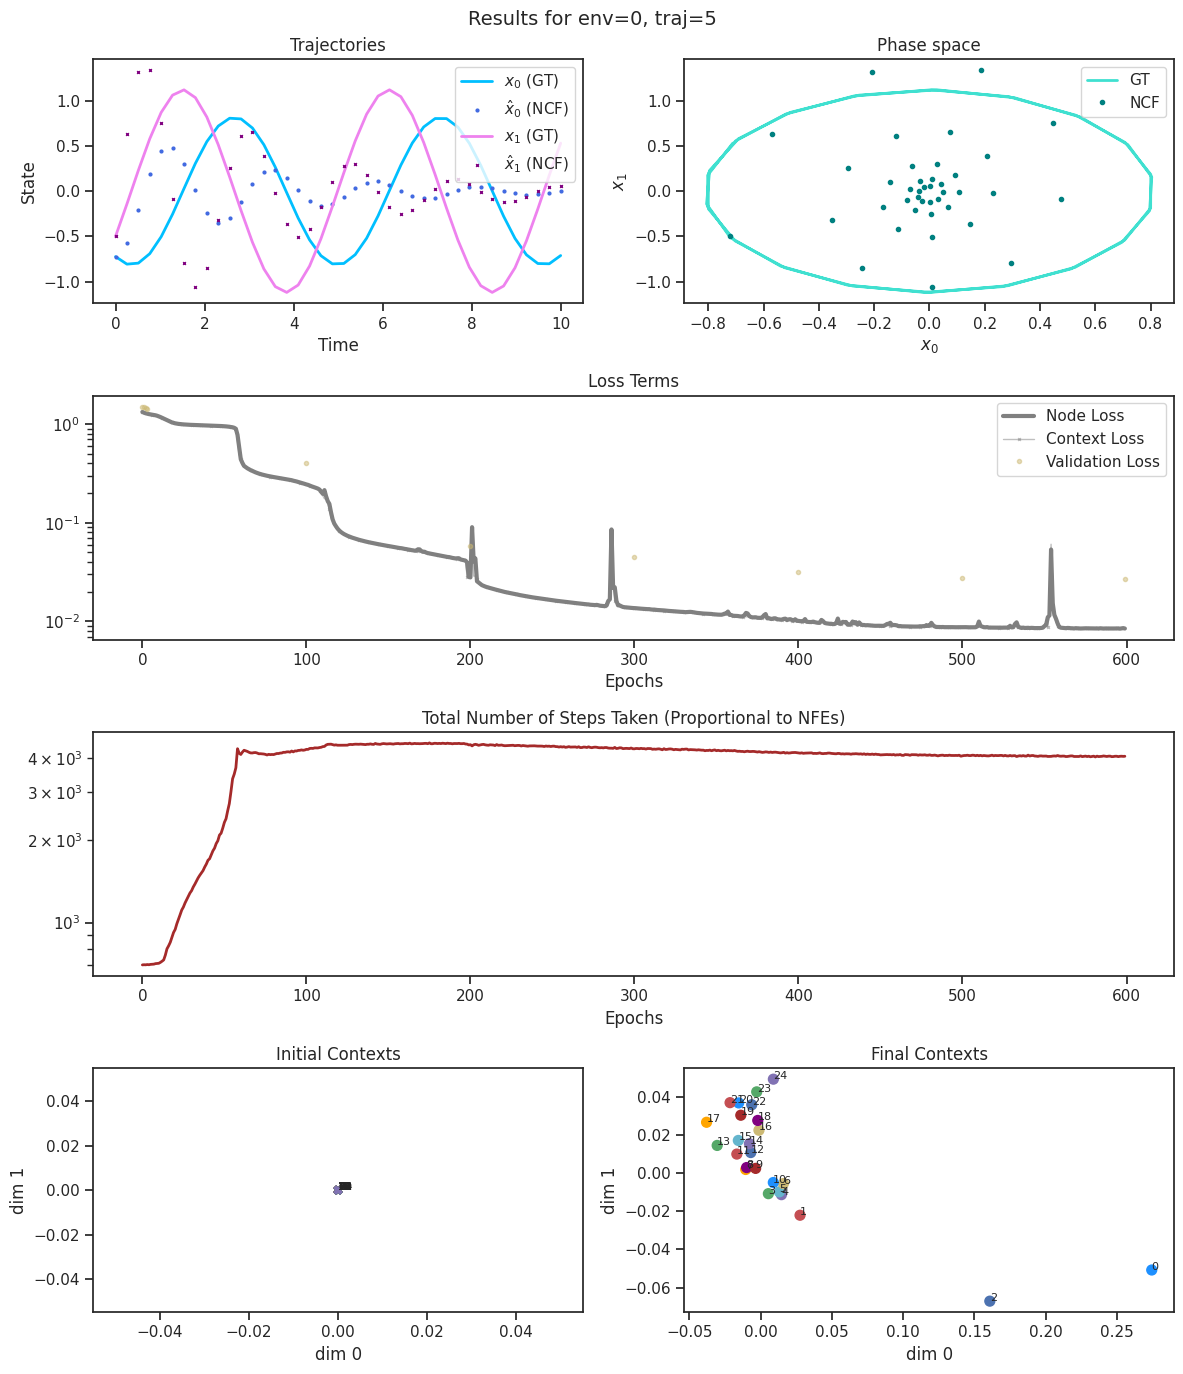

In [ ]:
#%%

## Test and visualise the results on a test dataloader

test_dataloader = DataLoader(run_folder+"test_data.npz", shuffle=False)
visualtester = VisualTester(trainer)
# ans = visualtester.trainer.nb_steps_node
# print(ans.shape)

ind_crit = visualtester.test(test_dataloader, int_cutoff=1.0)

if finetune:
    savefigdir = finetunedir+"results_in_domain.png"
else:
    savefigdir = run_folder+"results_in_domain.png"
visualtester.visualize(test_dataloader, int_cutoff=1.0, save_path=savefigdir);

Running this script in ipython (Jupyter) session ? False
=== Parsed arguments to generate data ===
 Split: adapt
 Savepath: ./runs/23012024-163033-T2/adapt/
 Seed: 6078

Running this script in ipython (Jupyter) session ? False
=== Parsed arguments to generate data ===
 Split: adapt_test
 Savepath: ./runs/23012024-163033-T2/adapt/
 Seed: 6078



=== Beginning sequential adaptation ... ===
    Number of examples in a batch: 1
    Number of train steps per epoch: 1
    Number of training epochs: 1500
    Total number of training steps: 1500

Adapting to environment 0 ...

Compiling function "train_step" for context ...
Shapes of elements in a batch: (1, 1, 40, 2) (40,)
    Epoch:     0     LossContext: 0.04157732
    Epoch:     1     LossContext: 0.04966675
    Epoch:     2     LossContext: 0.05150269
    Epoch:     3     LossContext: 0.01031531
    Epoch:   100     LossContext: 0.00024519
    Epoch:   200     LossContext: 0.00016619
    Epoch:   300     LossContext: 0.00016501
    Epoch:

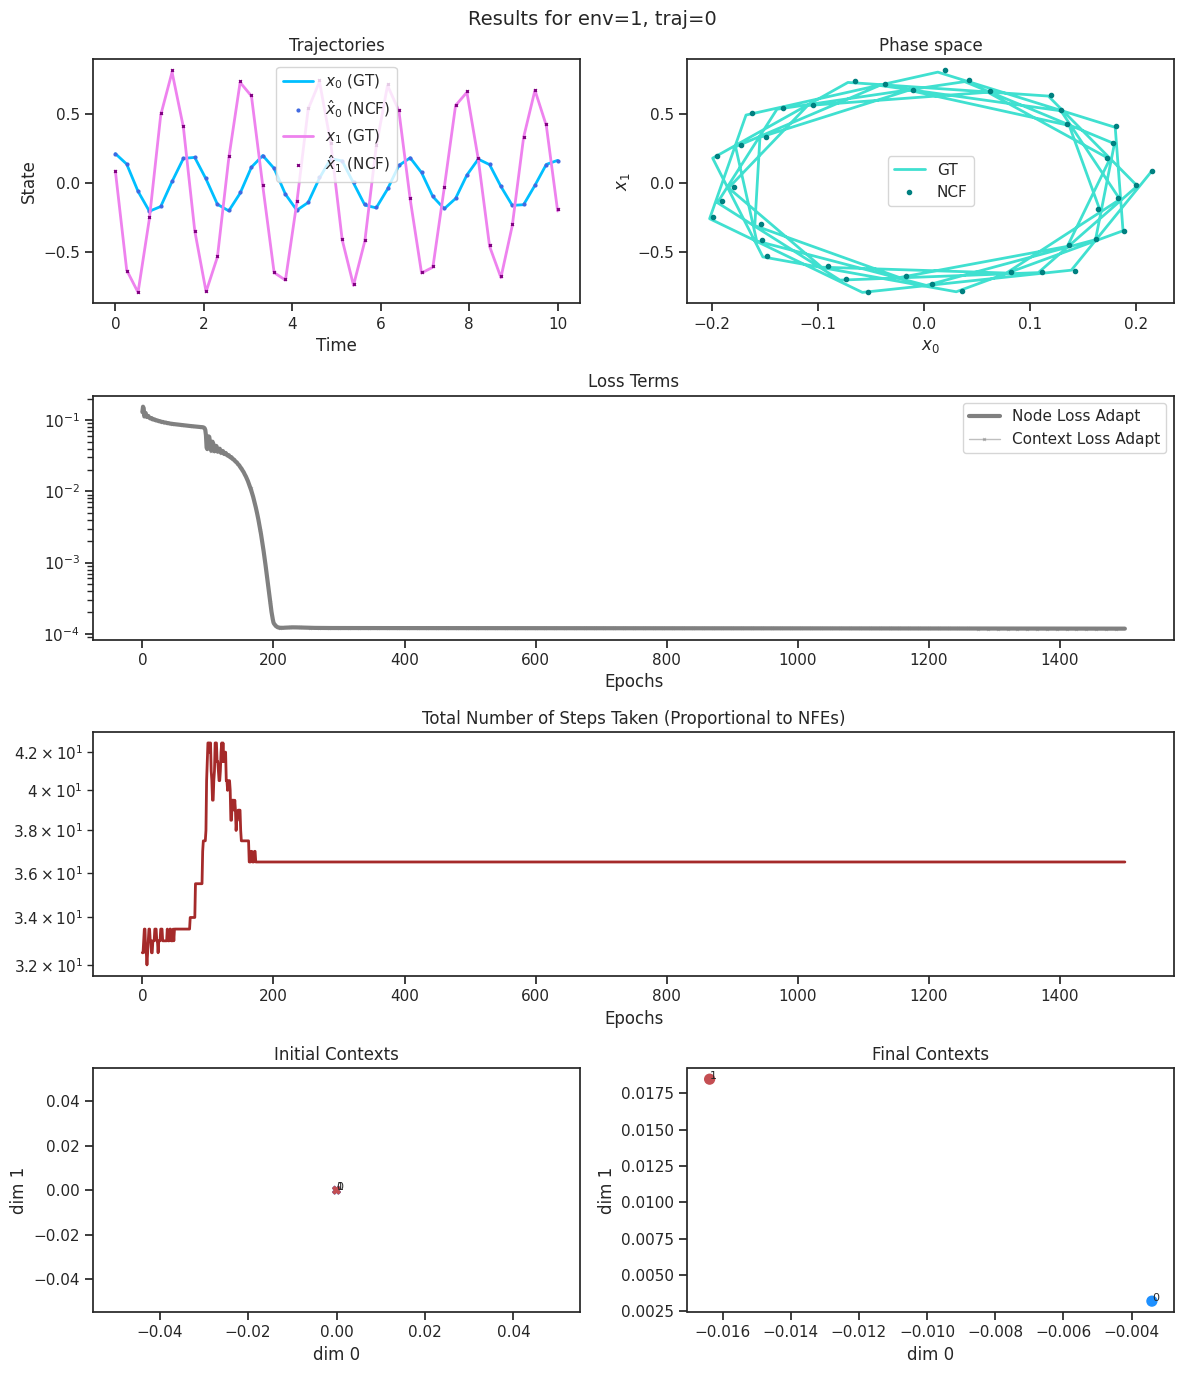

In [ ]:
#%%

## Give the dataloader an id to help with restoration later on
adapt_restore = False
if adapt_test and not adapt_restore:
    os.system(f'python dataset.py --split=adapt --savepath="{adapt_folder}" --seed="{seed*3}"');
    os.system(f'python dataset.py --split=adapt_test --savepath="{adapt_folder}" --seed="{seed*3}"');

if adapt_test:

    adapt_dataloader = DataLoader(adapt_folder+"adapt_data.npz", adaptation=True, data_id="170846", key=seed)
    adapt_dataloader_test = DataLoader(adapt_folder+"adapt_test_data.npz", adaptation=True, data_id="170846", key=seed)
    # print("shape of adapt_dataloader", adapt_dataloader.dataset.shape)

    sched_ctx_new = optax.piecewise_constant_schedule(init_value=init_lr_adapt,
                            boundaries_and_scales={nb_total_epochs//3:sched_factor_adapt, 2*nb_total_epochs//3:sched_factor_adapt})
    opt_adapt = optax.adabelief(sched_ctx_new)

    if adapt_restore == False:
        trainer.adapt_sequential(adapt_dataloader, nb_epochs=nb_epochs_adapt, optimizer=opt_adapt, print_error_every=print_error_every, save_path=adapt_folder)
    else:
        print("Save_id for restoring trained adapation model:", adapt_dataloader.data_id)
        trainer.restore_adapted_trainer(path=adapt_folder, data_loader=adapt_dataloader)

    ood_crit, ood_crit_all = visualtester.test(adapt_dataloader, int_cutoff=1.0)
    # contexts = np.append(contexts, trainer.learner.contexts.params)

    visualtester.visualize(adapt_dataloader, int_cutoff=1.0, save_path=adapt_folder+"results_ood.png");


    ood_crit, ood_crit_all = visualtester.test(adapt_dataloader_test, int_cutoff=1.0)